# Brain MRI Stroke Classification 
## Training a Convolutional Neural Network from Scratch. 
## Version 0.2

## Set up

### Modules

#### Published modules

In [1]:
# Data Manipulation
import numpy as np

# Machine Learning
## Training, validation and test sets
from sklearn.model_selection import train_test_split

# PyTorch
## Data loading
from torch.utils.data.dataloader import DataLoader
## Pre-processing
from torchvision import transforms
## Neural Network Architecture
import torch
import torch.nn as nn
## Optimisiation
from torch.optim import Adam
## Misc
from torchsummary import summary
from torch_snippets import show, inspect

# Utilities
## os
import os
import sys
## Paths
from pyhere import here
from glob import glob
## Garbage colector
import gc

#### Project specific modules

In [2]:
path_to_project_modules = os.path.join(here('Src','Modules'))
sys.path.insert(0, path_to_project_modules)

from Project.datautils import StrokeImageData # Class inheriting from torch.utils.data.dataset.Dataset to load images
from Project.visualisation import display_image_samples
from Project.architecture import convolution_layer2conv as convolution_layer # Similar to the architecture of VGGs but with batch normalisation
from Project.modeltraining import train_model, evaluate_model

### File paths

In [3]:
raw_data = os.path.join(here('Data', 'Raw')) #os.path.join transforms the output of pyhere.here from PosixPath to a text string
file_paths = glob(raw_data + '/*/*')

#### Random state

In [4]:
rand_state = 13 # For replication purposes
torch.manual_seed(rand_state)

#### PyTorch Backend

In [5]:
# Ensure the workflow is device agnostic 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} as Hardware Accelerator')

Using cuda as Hardware Accelerator


## Analysis

### Data loading and preparation

#### Data pre-processing

In [6]:
preproc_recipe = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor() # also performs normalises the data to values between 0 and 1
])

#### Train, validation and test sets

In [7]:
# Store classes in a list (for stratification)
y = [_file_path.split('/')[-2] for _file_path in file_paths]

# Generate Training and test sets
X_trainval, x_test, y_trainval, _ = train_test_split(file_paths, y, test_size=0.2, shuffle=True, stratify=y, random_state=rand_state)

# Further split training set into training and validation sets
X_train, X_val = train_test_split(X_trainval, test_size = 0.2, shuffle=True, stratify=y_trainval, random_state=rand_state)

#### Data loading

In [8]:
strk_train = StrokeImageData(X_train, device = device, recipe = preproc_recipe)
strk_val = StrokeImageData(X_val, device = device, recipe = preproc_recipe)
strk_test = StrokeImageData(x_test, device = device, recipe = preproc_recipe)

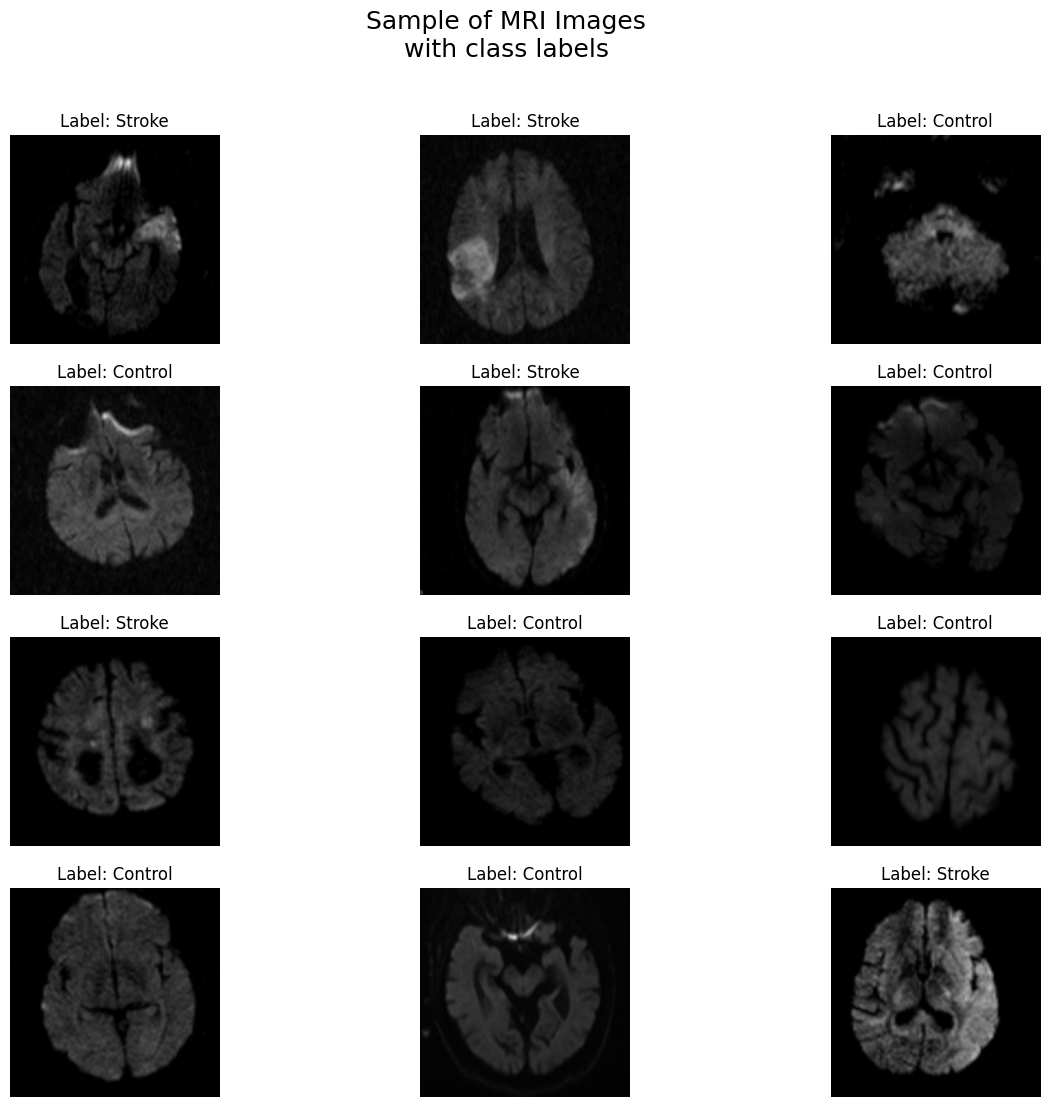

In [9]:
# Check Images are loaded correctly
display_image_samples(strk_train)

#### Data loaders

In [10]:
batch_size = 32

train_dl = DataLoader(strk_train, batch_size = batch_size, shuffle = True, drop_last = True) # Drop last batch as it only contains 6 images

val_dl = DataLoader(strk_val, batch_size = batch_size, shuffle = True, drop_last = True) # Drop last batch as it only contains 2 images

test_dl = DataLoader(strk_test, batch_size = batch_size, shuffle = True, drop_last = False)

### Model specification

#### Network Architecture

In [36]:
m_two = nn.Sequential(
    convolution_layer(3, 512, 3),
    convolution_layer(512, 512, 3),
    convolution_layer(512, 256, 3),
    convolution_layer(256, 128, 3),
    convolution_layer(128, 64, 3),
    nn.Flatten(),
    nn.Linear(576,200),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(200,1),
    nn.Sigmoid()
).to(device)

In [38]:
summary(m_two, input_size=(3,224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 222, 222]              84
              ReLU-2          [-1, 3, 222, 222]               0
       BatchNorm2d-3          [-1, 3, 222, 222]               6
            Conv2d-4        [-1, 512, 220, 220]          14,336
              ReLU-5        [-1, 512, 220, 220]               0
       BatchNorm2d-6        [-1, 512, 220, 220]           1,024
         MaxPool2d-7        [-1, 512, 110, 110]               0
            Conv2d-8        [-1, 512, 108, 108]       2,359,808
              ReLU-9        [-1, 512, 108, 108]               0
      BatchNorm2d-10        [-1, 512, 108, 108]           1,024
           Conv2d-11        [-1, 512, 106, 106]       2,359,808
             ReLU-12        [-1, 512, 106, 106]               0
      BatchNorm2d-13        [-1, 512, 106, 106]           1,024
        MaxPool2d-14          [-1, 512,

### Hyperparameters

#### Epochs

In [39]:
n_epochs = 500

#### Optimiser

In [40]:
optim = Adam
lr = 1e-3

# learning rate annealing
scheduler_kws = {
    'factor':0.5, 
    'patience':0, 
    'threshold':1e-3, 
    'verbose':True, 
    'min_lr':1e-6, 
    'threshold_mode':'abs'}

# Early stop
earlystop_kws = {
    'patience': 5,
    'min_delta': 1e-3
}

#### Loss Function

In [41]:
loss_fn = nn.BCELoss() # Binary Cross Entropy

#### Model training

Learning rate annealing enabled...
Early stop enabled...
Epoch: 1;
Training accuracy: 72.66%, Training loss: 0.52168 ---------- Validation accuracy: 50.00%, Validation loss: 0.85877
Epoch: 2;
Training accuracy: 82.89%, Training loss: 0.38326 ---------- Validation accuracy: 85.94%, Validation loss: 0.39616
Epoch: 3;
Training accuracy: 87.50%, Training loss: 0.29009 ---------- Validation accuracy: 78.12%, Validation loss: 0.52577
Epoch 00003: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 4;
Training accuracy: 92.89%, Training loss: 0.18845 ---------- Validation accuracy: 90.00%, Validation loss: 0.25539
Epoch: 5;
Training accuracy: 95.16%, Training loss: 0.13870 ---------- Validation accuracy: 94.06%, Validation loss: 0.14093
Epoch: 6;
Training accuracy: 94.61%, Training loss: 0.13146 ---------- Validation accuracy: 92.50%, Validation loss: 0.18987
Epoch 00006: reducing learning rate of group 0 to 2.5000e-04.
Epoch: 7;
Training accuracy: 97.34%, Training loss: 0.08806 ---------

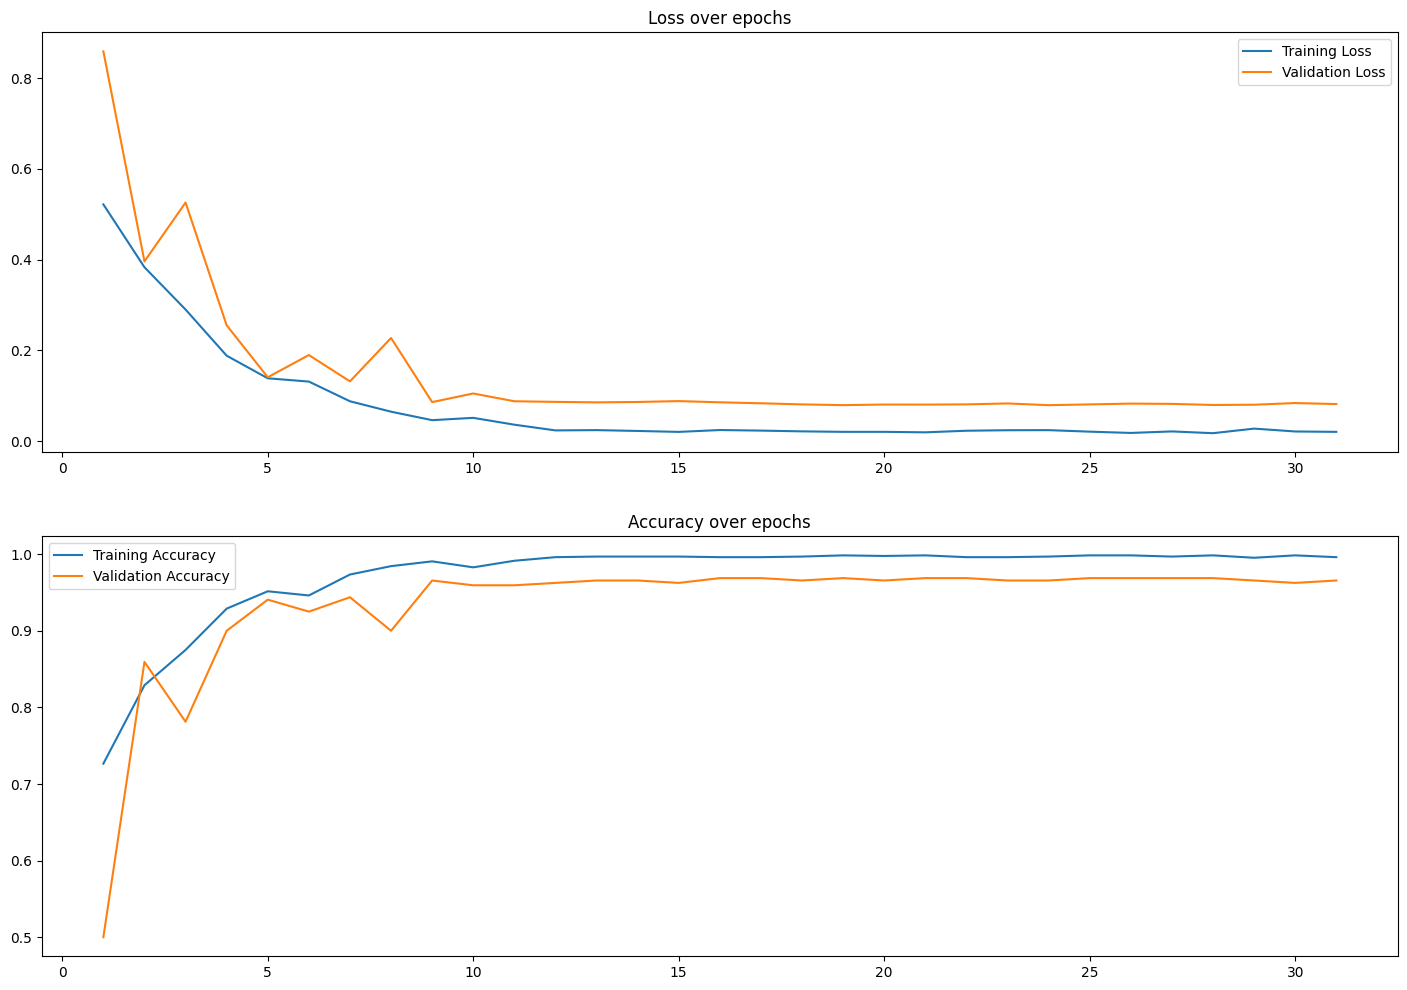

In [43]:
train_model(train_dl, val_dl, m_two, loss_fn, optim, lr, n_epochs, kws_lr_scheduler = scheduler_kws, kws_early_stop = earlystop_kws)

## Performance in the Test set

In [45]:
test_acc, test_loss = evaluate_model(test_dl, m_two, loss_fn, 0.5)
print(f"Test data:\n  Accuracy: {test_acc*100:.2f}%\n  Loss:    {test_loss:.5f}")

Test data:
  Accuracy: 95.77%
  Loss:    0.09718
